# Colab에 필요한 모듈 설치

In [ ]:
%%bash
apt-get update
apt-get install g++ openjdk-8-jdk python-dev python3-dev
pip3 install JPype1
pip3 install konlpy

In [4]:
%env JAVA_HOME "/usr/lib/jvm/java-8-openjdk-amd64"

env: JAVA_HOME="/usr/lib/jvm/java-8-openjdk-amd64"


In [5]:
%%bash
bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)
pip3 install /tmp/mecab-python-0.996

Installing automake (A dependency for mecab-ko)
Hit:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:3 http://security.ubuntu.com/ubuntu bionic-security InRelease
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:7 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:10 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:12 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:13 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:14 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:15 http://ppa

debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 5.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 1381k  100 1381k    0     0   513k      0  0:00:02  0:00:02 --:--:--  807k
./configure: line 7378: /usr/bin/file: No such file or directory
In file included from viterbi.cpp:14:0:
param.h:30:13: warning: 'Target {anonymous}::lexical_cast(Source) [with Target = std::__cxx11::basic_string<char>; Source = std::_

In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [6]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter

# 데이터를 읽어봅시다. 
train_data = pd.read_table('gdrive/MyDrive/Colab Notebooks/ratings_train.txt')
test_data = pd.read_table('gdrive/MyDrive/Colab Notebooks//ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


데이터의 중복 제거
NaN 결측치 제거
한국어 토크나이저로 토큰화
불용어(Stopwords) 제거
사전word_to_index 구성
텍스트 스트링을 사전 인덱스 스트링으로 변환
X_train, y_train, X_test, y_test, word_to_index 리턴

In [7]:
from konlpy.tag import Mecab
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
        
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)
            
    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000 - 4)
    vocab = ['','','',''] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
    
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]
    
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
    
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

In [8]:
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [9]:
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [10]:
word_to_index = {k:v for k,v in word_to_index.items()}

# 처음 몇 개 인덱스를 정의
word_to_index["<PAD>"] = 0
word_to_index["<BOS>"] = 1
word_to_index["<UNK>"] = 2  # unknown
word_to_index["<UNUSED>"] = 3

index_to_word = {index:word for word, index in word_to_index.items()}

print(index_to_word[1])     #출력확인
print(index_to_word[3])

<BOS>
<UNUSED>


# 모델구성을 위한 데이터 분석 및 가공

In [11]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

In [12]:
import seaborn as sns

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


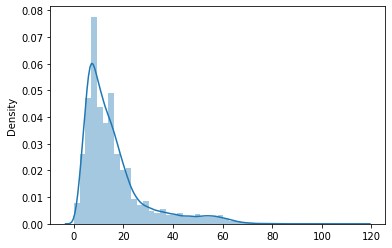

In [13]:
sns.distplot(num_tokens)

In [14]:

# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

문장길이 평균 :  15.969376315021577
문장길이 최대 :  116
문장길이 표준편차 :  12.843535456326455


In [15]:
#최대 길이를 (평균 + 2*표준편차)로 설정
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [16]:
X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre',
                                                        maxlen=maxlen)

X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre',
                                                       maxlen=maxlen)


In [17]:
val_len = int(len(X_train) * 0.3)

In [18]:
X_val = X_train[-val_len: ]
y_val = y_train[-val_len: ]

In [19]:
X_train = X_train[:-val_len]
y_train = y_train[:-val_len] 

# 다양한 모델 구현

## 1. LSTM

In [20]:
vocab_size = 10000  # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 200  # 단어 하나를 표현하는 임베딩 벡터의 차원수입니다. 

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 30)          300000    
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 1248      
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 301,329
Trainable params: 301,329
Non-trainable params: 0
_________________________________________________________________


In [21]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
epochs=20   

history = model.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/20
200/200 [==============================] - 11s 21ms/step - loss: 0.4970 - accuracy: 0.7731 - val_loss: 0.3754 - val_accuracy: 0.8392
Epoch 2/20
200/200 [==============================] - 4s 19ms/step - loss: 0.3359 - accuracy: 0.8585 - val_loss: 0.3544 - val_accuracy: 0.8461
Epoch 3/20
200/200 [==============================] - 4s 18ms/step - loss: 0.3119 - accuracy: 0.8697 - val_loss: 0.3524 - val_accuracy: 0.8481
Epoch 4/20
200/200 [==============================] - 4s 18ms/step - loss: 0.2979 - accuracy: 0.8759 - val_loss: 0.3566 - val_accuracy: 0.8447
Epoch 5/20
200/200 [==============================] - 4s 18ms/step - loss: 0.2859 - accuracy: 0.8814 - val_loss: 0.3546 - val_accuracy: 0.8476
Epoch 6/20
200/200 [==============================] - 4s 18ms/step - loss: 0.2745 - accuracy: 0.8871 - val_loss: 0.3624 - val_accuracy: 0.8448
Epoch 7/20
200/200 [==============================] - 4s 18ms/step - loss: 0.2637 - accuracy: 0.8920 - val_loss: 0.3588 - val_accuracy: 0.847

In [22]:
history_dict = history.history

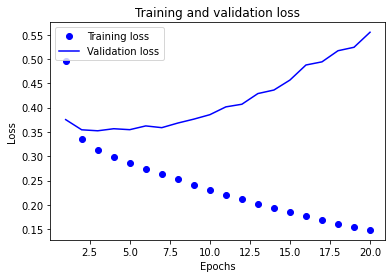

In [23]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

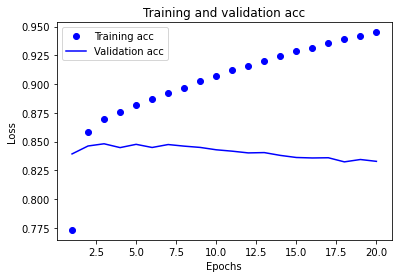

In [24]:
epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, acc, 'bo', label='Training acc')
# b는 "파란 실선"입니다
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation acc')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

그래프를 보면 점점 학습을 진행할수록 점점 과적합되는것을 확인할 수 있다.

## 2. conv1d

In [73]:
vocab_size = 10000  # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 200   # 단어 하나를 표현하는 임베딩 벡터의 차원 수입니다. 

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.MaxPooling1D(5))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, None, 200)         2000000   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 16)          22416     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, None, 16)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 16)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                

In [74]:
# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/20
200/200 [==============================] - 11s 49ms/step - loss: 0.4537 - accuracy: 0.7799 - val_loss: 0.3517 - val_accuracy: 0.8438
Epoch 2/20
200/200 [==============================] - 9s 47ms/step - loss: 0.2993 - accuracy: 0.8752 - val_loss: 0.3341 - val_accuracy: 0.8554
Epoch 3/20
200/200 [==============================] - 10s 49ms/step - loss: 0.2339 - accuracy: 0.9076 - val_loss: 0.3502 - val_accuracy: 0.8529
Epoch 4/20
200/200 [==============================] - 9s 47ms/step - loss: 0.1618 - accuracy: 0.9410 - val_loss: 0.4155 - val_accuracy: 0.8454
Epoch 5/20
200/200 [==============================] - 9s 47ms/step - loss: 0.1035 - accuracy: 0.9653 - val_loss: 0.4754 - val_accuracy: 0.8417
Epoch 6/20
200/200 [==============================] - 9s 47ms/step - loss: 0.0651 - accuracy: 0.9791 - val_loss: 0.5468 - val_accuracy: 0.8373
Epoch 7/20
200/200 [==============================] - 10s 49ms/step - loss: 0.0434 - accuracy: 0.9867 - val_loss: 0.6362 - val_accuracy: 0.8

In [75]:
# 테스트셋을 통한 모델 평가
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 4s - loss: 1.2414 - accuracy: 0.8226
[1.2414287328720093, 0.8225888609886169]


## 3. Global Maxpooling만 이용

In [78]:
vocab_size = 10000  # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 200   # 단어 하나를 표현하는 임베딩 벡터의 차원 수입니다. 

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, None, 200)         2000000   
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 200)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 8)                 1608      
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 9         
Total params: 2,001,617
Trainable params: 2,001,617
Non-trainable params: 0
_________________________________________________________________


In [79]:
# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/20
200/200 [==============================] - 9s 41ms/step - loss: 0.4757 - accuracy: 0.8040 - val_loss: 0.3605 - val_accuracy: 0.8411
Epoch 2/20
200/200 [==============================] - 8s 40ms/step - loss: 0.3121 - accuracy: 0.8680 - val_loss: 0.3422 - val_accuracy: 0.8512
Epoch 3/20
200/200 [==============================] - 8s 40ms/step - loss: 0.2616 - accuracy: 0.8938 - val_loss: 0.3475 - val_accuracy: 0.8524
Epoch 4/20
200/200 [==============================] - 8s 40ms/step - loss: 0.2194 - accuracy: 0.9148 - val_loss: 0.3642 - val_accuracy: 0.8504
Epoch 5/20
200/200 [==============================] - 8s 41ms/step - loss: 0.1776 - accuracy: 0.9350 - val_loss: 0.3869 - val_accuracy: 0.8492
Epoch 6/20
200/200 [==============================] - 8s 41ms/step - loss: 0.1364 - accuracy: 0.9541 - val_loss: 0.4217 - val_accuracy: 0.8449
Epoch 7/20
200/200 [==============================] - 8s 41ms/step - loss: 0.0996 - accuracy: 0.9698 - val_loss: 0.4613 - val_accuracy: 0.8417

In [80]:
# 테스트셋을 통한 모델 평가
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.8191 - accuracy: 0.8341
[0.8191279768943787, 0.8340622782707214]


3개의 모델 모두 과적합되는것을 확인할 수 있는데 이는 모델 내에 정규화가 필요함을 알 수 있는 부분이다.

### 모델에서 학습한 embedding vector

In [31]:
vocab_size = 10000  # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 30  # 단어 하나를 표현하는 임베딩 벡터의 차원수입니다. 

In [32]:
import os

# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = 'gdrive/MyDrive/Colab Notebooks/my_Embedding.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [33]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['즐거움']
vector

array([-0.0509347 , -0.02880649, -0.17664693,  0.02921618, -0.10903943,
        0.16693133, -0.07878617, -0.02690468, -0.05247477,  0.19813527,
       -0.00033545,  0.07256284, -0.01707846, -0.03347726, -0.07481491,
        0.02847742,  0.05782884,  0.10115124, -0.03219204, -0.1942604 ,
       -0.07315685,  0.04949372, -0.16888805,  0.01270435, -0.0332282 ,
        0.03582158,  0.01351559,  0.03855591,  0.16397919,  0.14911094],
      dtype=float32)

In [34]:
word_vectors.similar_by_word("영화")

[('드라마', 0.7890081405639648),
 ('페미니즘', 0.7715717554092407),
 ('준다', 0.7511979341506958),
 ('겅', 0.7493304014205933),
 ('리스트', 0.7375398278236389),
 ('드', 0.7327516674995422),
 ('요리', 0.7292343974113464),
 ('르노', 0.7215213775634766),
 ('점', 0.7200272083282471),
 ('왜', 0.7147977352142334)]

### 사전학습 embedding vector

In [35]:
from gensim.models import KeyedVectors, Word2Vec

In [36]:
import gensim
gensim.__version__

'3.6.0'

In [37]:
#model = KeyedVectors.load(model_path)
pretrained_word2vec_path =  'gdrive/MyDrive/Colab Notebooks/ko.bin'
pre_word2vec = gensim.models.Word2Vec.load(pretrained_word2vec_path)

In [38]:
pre_word2vec.similar_by_word("영화")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  """Entry point for launching an IPython kernel.


[('다큐멘터리', 0.7265259027481079),
 ('영화사', 0.715214192867279),
 ('드라마', 0.705294132232666),
 ('뮤지컬', 0.6947016716003418),
 ('코미디', 0.69093257188797),
 ('영화인', 0.6702202558517456),
 ('서부극', 0.6571458578109741),
 ('스릴러', 0.6533164978027344),
 ('로맨스', 0.6428799629211426),
 ('애니메이션', 0.6425570249557495)]

사전학습된 한국어 word2vec이 더욱더 입력한 단어와 비슷한 의미를 갖는 단어를 찾아줌을 알 수 있다.

In [42]:
pre_word2vec['영화'].shape 
#200개 차원을 가진 weight matrix를 갖음을 알 수 있다.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


(200,)

In [44]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in pre_word2vec:
        embedding_matrix[i] = pre_word2vec[index_to_word[i]]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


In [59]:
!pip install tensorflow-addons
import tensorflow_addons as tfa
from keras.regularizers import l2

     |████████████████████████████████| 679 kB 4.1 MB/s 


In [ ]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원 수 



lnLSTMCell = tfa.rnn.LayerNormLSTMCell(20, recurrent_dropout=0.2, dropout=0.15, kernel_regularizer=l2(0.015), recurrent_regularizer=l2(0.015))


rnn = keras.layers.RNN(lnLSTMCell, return_sequences=False, return_state=False)




# 모델 구성
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(rnn)  # 위에서 정의한 레이어를 쌓아 줍니다
model.add(keras.layers.Dense(30, activation='relu', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

## LayerNormLSTMCell API이용

- LayerNormalization(LN)은 각 feature들에 대해 normalizaiton을 진행하기 때문에 BatchnNormalization과는 달리 배치의 수에 따라 영향을 받지 않는다. 

- RNN모델에서 training 시간과 genalization을 잘 수행해주며, 최근 transfer모델에 사용된다고 한다.

- RNN Network에서는 기본적인 Dropout Layer를 사용하게 되면 중요한 과거 정보를 잃어버릴 확률이 높아지게 되고 따라서 Model의 성능이 나빠지므로 특정방법으로 Dropout을 진행행야되는데 이를 LayerNormLSTMCell이 수행한다

In [62]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

EPOCH = 20
BATCH_SIZE = 512

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

filename = 'checkpoint-epoch-{}-batch-{}-trial-001.h5'.format(EPOCH, BATCH_SIZE)
checkpoint = ModelCheckpoint(filename,             # file명을 지정합니다
                             monitor='val_loss',   # val_loss 값이 개선되었을때 호출됩니다
                             verbose=1,            # 로그를 출력합니다
                             save_best_only=True,  # 가장 best 값만 저장합니다
                             mode='auto'           # auto는 알아서 best를 찾습니다. min/max
                            )

earlystopping = EarlyStopping(monitor='val_loss',  # 모니터 기준 설정 (val loss) 
                              patience=5,         # 5회 Epoch동안 개선되지 않는다면 종료
                             )
history = model.fit(X_train,
                    y_train,
                    epochs=EPOCH,
                    batch_size=BATCH_SIZE,
                    validation_data=(X_val, y_val),
                    callbacks = [checkpoint, earlystopping],
                    verbose=1)

Epoch 1/20
200/200 [==============================] - 69s 328ms/step - loss: 1.4379 - accuracy: 0.6530 - val_loss: 0.6738 - val_accuracy: 0.7988

Epoch 00001: val_loss improved from inf to 0.67380, saving model to checkpoint-epoch-20-batch-512-trial-001.h5
Epoch 2/20
200/200 [==============================] - 66s 330ms/step - loss: 0.5546 - accuracy: 0.8125 - val_loss: 0.4610 - val_accuracy: 0.8339

Epoch 00002: val_loss improved from 0.67380 to 0.46101, saving model to checkpoint-epoch-20-batch-512-trial-001.h5
Epoch 3/20
200/200 [==============================] - 66s 329ms/step - loss: 0.4353 - accuracy: 0.8409 - val_loss: 0.4123 - val_accuracy: 0.8471

Epoch 00003: val_loss improved from 0.46101 to 0.41231, saving model to checkpoint-epoch-20-batch-512-trial-001.h5
Epoch 4/20
200/200 [==============================] - 65s 327ms/step - loss: 0.3938 - accuracy: 0.8532 - val_loss: 0.3941 - val_accuracy: 0.8502

Epoch 00004: val_loss improved from 0.41231 to 0.39412, saving model to che

# 테스트 결과

In [68]:
import tensorflow as tf

In [71]:
#성능이 가장 좋았던 모델 불러오기
model = keras.models.load_model('/content/checkpoint-epoch-20-batch-512-trial-001.h5')

In [72]:
# 테스트셋을 통한 모델 평가
results = model.evaluate(X_test,  y_test, verbose=2)
print(results)

1537/1537 - 29s - loss: 0.3684 - accuracy: 0.8563
[0.36843636631965637, 0.8562564849853516]


정확도가 85.6%가 나온것을 확인할 수 있었다.

# 회고

클라우드 상에서 gensim이 다운그래드가 되지않아 코랩을 이욯하였다 ㅠㅠ

형준님이 올려주신 LayerNormLSTMCell를 참고하였고, 관련된 문서를 읽으면서 LN과 Dropout에 대해 정리해볼 수 있는 좋은 시간이였다.